The idea of the project is to redo the analysis from [Baryonic Feedback Biases on Fundamental Physics from Lensed CMB Power Spectra](https://arxiv.org/abs/2103.05582) with MCMC, and then have a pipeline that can be used for new models.

In [4]:
# only needed once
#!pip install camb # only installs for default kernel?
#!pip install emcee

In [5]:
#!pip install cosmopower # requires tensorflow which is 500 MB, can take upto 2 GB with all dependencies

In [6]:
#import cosmopower

In [1]:
import os
import sys # to get the Python version
#import time
import camb
import emcee # for running MCMC
import corner
import numpy as np
import astropy.units as u
import multiprocessing as multi
import matplotlib.pyplot as plt
from astropy.constants import c # speed of light
from scipy import interpolate, integrate

#sys.path.append(os.path.abspath("bulk_data/BCemu/src/BCemu")) # local repo location
#import BaryonEffectsEmulator as BCemu

print("Python version:", sys.version)    # 3.9.7
print("CAMB version:", camb.__version__) # version 1.5.9
print("Astropy units:", c.reference)     # CODATA 2018
cpus_to_use = multi.cpu_count()//2

print(f"Using up to {cpus_to_use} of {multi.cpu_count()} CPUs.")

plt.rc('axes', labelsize=15) # fontsize of the x- and y-axis labels
plt.rc('axes', titlesize=17) # fontsize of the axes title
x_label_multipole = r'multipole $\ell$' # I use l in Overleaf though

folder = "bulk_data/code_output/"
mcmc_folder            = folder+"mcmc_runs/"
cmb_spectra_folder     = folder+"cmb_power_spectra/"
lensing_spectra_folder = folder+"lensing_power_spectra/"

Python version: 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
CAMB version: 1.5.9
Astropy units: CODATA 2018
Using up to 96 of 192 CPUs.


In [2]:
# save parameters seperately to use them later:    
n_redshifts = 10 # number of redshifts to calculate for Transfer functions, and, by extension, the matter power interpolator
k_max = 100/u.Mpc # high k_max makes the CAMB calculations a lot slower. Above some value in the range (4150, 4200] Mpc it will error
parameters = {"H0":67.32,                # Hubble constant [km/s/Mpc]
              "ombh2":0.022383,          # density parameter for 'baryonic' matter times the dimensionless reduced hubble constant squared at the present[]
              "omch2":0.12011,           # density parameter for cold dark matter times the dimensionless reduced hubble constant squared at the present[]
              "tau":0.0543,              # optical depth of reionization []
              "As":2.1e-9,               # initial super-horizon amplitude of curvature perturbations [] at 0.05 Mpc**-1 by default
              "ns":0.96605,              # scalar spectral index []
              #"nnu":3.046,               # effective number of relativistic species []
              "omk":0,                   # spatial curvature density parameter []
              "mnu":0.06,                # sum of neutrino masses [eV]
              "r":0,                     # tensor to scalar ratio at pivot []
              "HMCode_A_baryon":3.13,    # halo concentration multiplier []
              "HMCode_eta_baryon":0.603  #
             }
parameters_latex={"H0":r"H_0",
                  "ombh2":r"\Omega_b h^2",
                  "omch2":r"\Omega_c h^2",
                  "tau":r"\tau",
                  "As":r"A_s",
                  "ln(As)":r"\ln(A_s)",
                  "log(As)":r"\log(A_s)",
                  "ns":r"n_s",
                  "nnu":r"n_\nu", # or r"N_\mathrm{eff}" ?
                  "omk":r"\Omega_k",
                  "mnu":r"M_\nu",
                  "r":r"r",
                  "HMCode_A_baryon":r"A",
                  "HMCode_eta_baryon":r"\eta_0"}
# derived parameters:
H_0 = parameters["H0"]*u.km/u.s/u.Mpc # Hubble constant with units
h = parameters["H0"]/100 # dimensionless reduced Hubble constant []
Om_m = (parameters["ombh2"] + parameters["omch2"])/h**2 # density parameter for total matter at the present []
Om_b = parameters["ombh2"]/h**2 # density parameter for non-dark matter at the present []
#scale_matter_lambda = (Om_m/(1-Om_m))**(1/3) # cosmic scale factor at matter-Lambda equality, assumes the universe is flat []
#t_factor = 3*H_0/2 * (1 - Om_m)**0.5 # multiplication factor to make time dimensionless [Hz]

pars = camb.set_params(**parameters, WantTransfer=True) # need transfer functions to get the matter power spectrum
pars.Transfer = camb.model.TransferParams(high_precision=True, accurate_massive_neutrinos=True, kmax=k_max*u.Mpc, PK_num_redshifts=n_redshifts, PK_redshifts=[*np.geomspace(1100, 1, n_redshifts-1), 0]) # redshifts must be in decreasing order
pars.NonLinear = camb.model.NonLinear_both # just a string

pars.NonLinearModel.set_params('mead2020', HMCode_A_baryon = parameters["HMCode_A_baryon"], HMCode_eta_baryon = parameters["HMCode_eta_baryon"]) # mead2020 has no baryonic feedback, McCarthy uses mead2016

pars.set_for_lmax(10000, lens_potential_accuracy=8, lens_margin=2050);
pars.set_accuracy(AccuracyBoost=2.0, lSampleBoost=2.0, lAccuracyBoost=2.0, DoLateRadTruncation=False)
pars.Accuracy.AccurateBB = True

# # default setting mentioned in paper:
# lmax = 5000
# pars.set_for_lmax(lmax, lens_potential_accuracy=0, lens_margin=150); 
# pars.set_accuracy(AccuracyBoost=1.0, lSampleBoost=1.0, lAccuracyBoost=1.0, DoLateRadTruncation=True); 

In [3]:
pars

class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_both
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = True
   kmax = 100.0
   k_per_logint = 0
   PK_num_redshifts = 10
   PK_redshifts = [1100.0, 458.3725477216993, 191.00490227716503, 79.59218516738036, 33.166247903553995, 13.820452318110469, 5.759014490653241, 2.399794676769919, 1.0, 0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 12050
 max_l_tensor = 600
 max_eta_k = 144000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.022383
 omch2 = 0.12011
 omk = 0.0
 omnuh2 = 0.000644866570625114
 H0 = 67.32
 TCMB = 2.7255
 YHe = 0.24586103149908384
 num_nu_massless = 2.0293333333333337
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.014666666666

In [4]:
# functions that are used in various locations:
cosmic_scale_factor = lambda z: 1/(z+1)

def integral(integrand, a, b, limit=200, epsabs=1e-8): # multiprocessing can't use locally defined functions!
    """
    Prepares an integrand for integration along its first argument.
    
    Input:
    integrand:function: takes n positional arguments, the integrand of the integral to return
    a        :float   : starting point of integration, can be infinite
    b        :float   : end point of integration, can be infinite
    limit    :int     : max number of subdivisions to evalutate integral, defualt is 200
    epsabs   :float   : desired integration error (absolute), default is 1e-8
    
    Return:
    curried_integral:function: takes n-1 positional arguments and returns the evaluated integral
    """
    global curried_integral # to make it picklable, for multiprocessing
    def curried_integral(args):
        return integrate.quad(integrand, a, b, args, limit=limit, epsabs=epsabs)
    return curried_integral

def save_array_and_print(filename, obj, filetype='npy', **kwargs):
    """
    Save objects using Numpy's save or savetxt functions. Only plain numpy arrays can be saved to txt.
    
    Input:
    filename:str: the object will be saved to filename.filetype
    obj     :any: the object to save
    filetype:str: filetype to save the object as. Options are npy and txt. Default is txt
    **kwargs:     other keyword arguments to pass to np.save or np.savetxt. Ex: header, format...
    """
    if filetype == 'npy':
        np.save(filename, obj, **kwargs)
        print(f"Saved data to {filename}.npy")
    elif filetype == 'txt':
        np.savetxt(filename+'.txt', obj, **kwargs)
        print(f"Saved data to {filename}.txt")
    else:
        raise NotImplementedError("Only saving to npy or txt files is possible now.")

def get_integrand_stuff(mode): # not used currently
    """Todo: replace with a function to get clkk (from interpolator?, or results object?)"""
    if mode == "Weyl":
        integrand = lambda chi, l: ((CMB_distance/u.Mpc - chi)/(CMB_distance/u.Mpc))**2 * matter_power_interpolator_weyl.P(redshift(chi), (l+0.5)/chi) # chi in Mpc # formula from CAMB demo, simplified
        factor = 1 # approximation, but quite accurate for l >> 1
        epsabs = 1e-8 * ((3/2 * Om_m * (H_0/c)**2)**2).to(u.Mpc**-4).value
    elif mode == "delta_tot":
        integrand = lambda chi, l: ((CMB_distance/u.Mpc - chi)/(cosmic_scale_factor(redshift(chi)) * CMB_distance/u.Mpc))**2 * matter_power_interpolator_tot.P(redshift(chi), (l+0.5)/chi) # chi in Mpc # formula from McCarthy
        factor = ((3/2 * Om_m * (H_0/c)**2)**2).to(u.Mpc**-4).value
        epsabs = 1e-8 # keep default
    else:
        raise ValueError('Only "Weyl" and "delta_tot" are supported modes.')
    return integrand, factor, epsabs

In [5]:
## cell can take a long time (upto an hour), only run if settings are changed (data is saved to files)
try:
    with open("parameters.txt", 'r') as text_file:
        pars_old_repr = text_file.read()
except FileNotFoundError:
    pars_old_repr = None

if repr(pars) != pars_old_repr or True:
    results = camb.get_results(pars) # takes a bit long, and can't be saved to a file
    
    CMB_power_spectra = results.get_cmb_power_spectra(CMB_unit='muK') # l(l+1)C_l /(2pi) in units of \mu K^2 against multipole l # takes about 3 minutes (longer for higher k_max)
    save_array_and_print(cmb_spectra_folder+"cmb_power_spectra", CMB_power_spectra) # CMB_power_spectra is a dictionary, so it will be wrapped in a 0-dim object array first
    
    universe_age = results.physical_time(0)*u.Gyr # cosmic time
    with open("universe_age.txt", 'w') as text_file:
        text_file.write(repr(universe_age.value))
        text_file.write(" * u.") # * for multiplication, u. for astropy.units
        text_file.write(repr(universe_age.unit))
    print("Saved data to universe_age.txt")

    CMB_distance = (results.tau0 - results.tau_maxvis)*u.Mpc # comoving distance
    with open("cmb_distance.txt", 'w') as text_file:
        text_file.write(repr(CMB_distance.value))
        text_file.write(" * u.") # * for multiplication, u. for astropy.units
        text_file.write(repr(CMB_distance.unit))
    print("Saved data to cmb_distance.txt")
    
    #CDM_power_spectrum = results.get_matter_power_spectrum(var1="delta_cdm", var2="delta_cdm", have_power_spectra=True, maxkh=k_max/h*u.Mpc) # pretty fast if have_power_spectra=True
    #save_array_and_print(cmb_spectra_folder+"cdm_power_spectrum", CDM_power_spectrum)
    
    with open("parameters.txt", "w") as text_file:
        text_file.write(repr(pars)) # ideally I would make it more readable with whitespace
    print("Saved data to parameters.txt")
else:
    results = None # so that its existence can easily be checked

Saved data to bulk_data/output/cmb_power_spectra/cmb_power_spectra.npy
Saved data to universe_age.txt
Saved data to cmb_distance.txt
Saved data to parameters.txt


In [6]:
## loading saved data from files
CMB_power_spectra = np.load(cmb_spectra_folder+'cmb_power_spectra.npy', allow_pickle=True)[()] # dictionary of (l(l+1)C_l/(2\pi), l) data, need to index with empty tuple to unpack from the 0-dim array it is put in for saving
CMB_power_spectra_labels = ["TT", "EE", "BB", "TE"]
CMB_power_spectra_lens_potential_labels = ["PP", "PT", "PE"]
CMB_power_spectra_unit = "\mu K^2"

with open("universe_age.txt", 'r') as text_file:
    universe_age = eval(text_file.read()) # cosmic time

with open("cmb_distance.txt", 'r') as text_file:
    CMB_distance = eval(text_file.read()) # comoving distance

## loading data from files downloaded from GitHub
folder = "./bulk_data/so_noise_models/LAT_comp_sep_noise/v3.1.0/"
file_names = {"N_lens_TT": "SO_LAT_Nell_T_atmv1_goal_fsky0p4_ILC_CMB.txt", # have to keep the order the same as CMB_power_spectra_labels
              "N_lens_EE": "SO_LAT_Nell_P_goal_fsky0p4_ILC_CMB_E.txt",
              "N_lens_BB": "SO_LAT_Nell_P_goal_fsky0p4_ILC_CMB_B.txt",
             }

noise_spectra = {"SO":{key:np.loadtxt(folder + file_name) for key, file_name in file_names.items()}} # C_l in muK^2
noise_spectrum_labels = ["multipole", "deproj-0", "deproj-1", "deproj-2", "deproj-3"]
# SO data has some Planck noise

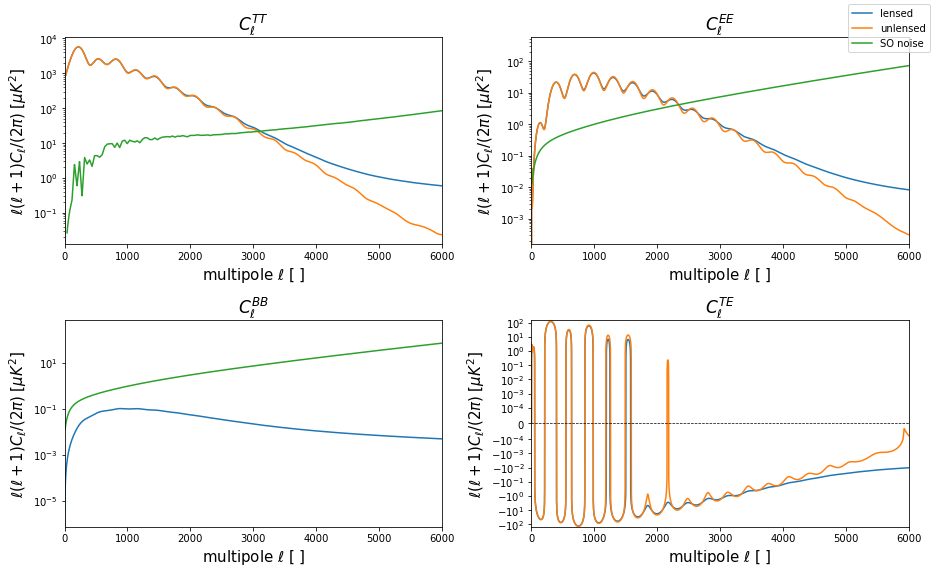

In [13]:
## figure 1 from first paper
if True:
    l_max = 6000 # set to -1 to remove limit for the graphs

    fig, frames = plt.subplots(2, 2, figsize=(13, 8))
    i = 0
    for frame_row in frames:
        for frame in frame_row:
            frame.plot(CMB_power_spectra["total"][:l_max,i],)# label="lensed")
            frame.plot(CMB_power_spectra["unlensed_total"][:l_max,i],)# label="unlensed")
            for survey, noise_data in noise_spectra.items():
                try: # check noise_spectra
                    key = "N_lens_" + CMB_power_spectra_labels[i]
                    l = noise_data[key][:,0]
                    frame.plot(l, l*(l+1)/(2*np.pi) * noise_data[key][:,1]) #label=f"{survey} noise")
                except KeyError:
                    pass
            frame.set_ylabel(fr"$\ell(\ell+1)C_\ell/(2\pi)\; [{CMB_power_spectra_unit}]$")
            frame.set_xlabel(r'multipole $\ell$ [ ]')
            frame.set_title(r"$C_\ell^{" + CMB_power_spectra_labels[i] + "}$")
            if l_max != -1:
                frame.set_xlim(0, l_max)
            else:
                frame.margins(0)
            frame.set_yscale("log")
            #frame.legend()
            i += 1
    frame.set_yscale("symlog", linthresh=1e-4)
    #frame.set_yscale("linear")
    frame.set_ylim(-150, 150)
    frame.axhline(0, c='k', ls='--', lw=0.7)
    fig.legend(['lensed', 'unlensed', f'{survey} noise'])
    fig.tight_layout()
    fig.savefig("fig_1")

#     fig, frame = plt.subplots()
#     frame.plot(CMB_power_spectra["total"][:l_max]/CMB_power_spectra["unlensed_total"][:l_max], lw=0.7)
#     frame.set_ylabel(r"$\frac{\tilde{C_\ell}}{C_\ell}$", fontsize=20)
#     frame.set_xlabel('$\ell$', fontsize=15)
#     frame.set_title("Lensed/Unlensed Ratios")
#     if l_max != -1:
#         frame.set_xlim(0, l_max)
#     frame.set_yscale("log")
#     frame.legend(CMB_power_spectra_labels)

#     fig, frame = plt.subplots()
#     frame.plot(CMB_power_spectra["total"][:l_max]/CMB_power_spectra["unlensed_total"][:l_max], lw=0.7)
#     frame.set_ylabel(r"$\frac{\tilde{C_\ell}}{C_\ell}$", fontsize=20)
#     frame.set_xlabel('$\ell$', fontsize=15)
#     frame.set_title("Lensed/Unlensed Ratios")
#     if l_max != -1:
#         frame.set_xlim(0, l_max)
#     frame.set_yscale("symlog") # asinh is pretty similar
#     frame.legend(CMB_power_spectra_labels)

#     fig, frame = plt.subplots()
#     frame.plot(CMB_power_spectra["total"][:l_max]/CMB_power_spectra["unlensed_total"][:l_max], lw=0.7)
#     frame.set_ylabel(r"$\frac{\tilde{C_\ell}}{C_\ell}$", fontsize=20)
#     frame.set_xlabel('$\ell$', fontsize=15)
#     frame.set_title("Lensed/Unlensed Ratios")
#     if l_max != -1:
#         frame.set_xlim(0, l_max)
#     frame.set_ylim(-1, 10)
#     frame.legend(CMB_power_spectra_labels)

In [14]:
# loading data for figure 3 (power spectra ratios for different models)
matter_power_spectra_directory = "./bulk_data/power_spectrum_library/"

matter_power_spectra_names = []
for file in os.listdir(matter_power_spectra_directory):
    split_name = file.split('.')
    if split_name.pop() == 'dat':
        fil = '.'.join(split_name)
        matter_power_spectra_names.append('_'.join(fil.split('_')[:-1]))

matter_power_spectra_names.remove('BAHAMAS') # handle seperately
matter_power_spectra = {label:{name: np.loadtxt(matter_power_spectra_directory + name + "_"+ label + ".dat") for name in matter_power_spectra_names if not (label == 'dmo' and 'BAHAMAS' in name)} for label in ["dmo", "hydro"]}
matter_power_spectrum_columns = ['redshift', 'wavenumber', 'power', 'delta^2'] #[], [h/Mpc], [(Mpc/h)**3], []

bahamas_dmo_mps = np.loadtxt(matter_power_spectra_directory+"BAHAMAS_dmo.dat")
for qualifier in ['High', 'Mid', 'Low']:
    matter_power_spectra['dmo'][f'BAHAMAS-{qualifier}AGN'] = bahamas_dmo_mps # they all have the same DMO matter power spectrum

In [8]:
## getting the matter power interpolator(s)

# todo: try using cosmopower to see if it is faster and gives the same results

mode = "delta_tot" # "Weyl" or "delta_tot", case sensitive. delta_tot is recommended

if mode == "weyl":
    mode = "Weyl"
    
if results and True: # can be a bit slow, so I don't want to run this every time
    if results and pars.Transfer.PK_num_redshifts > 5: # fast, but the interpolators can be wonky if n_redshifts is low (5 was bad, 10 was good)
        # t0 = time.time()
        matter_power_interpolator = results.get_matter_power_interpolator(var1=mode, var2=mode, hubble_units=False, k_hunit=False) # units depend on the mode
        # t1 = time.time()
        # print(t1-t0)
        matter_power_interpolator_tot  = results.get_matter_power_interpolator(var1='delta_tot', var2='delta_tot', hubble_units=False, k_hunit=False) # output is in Mpc**3 units
        matter_power_interpolator_weyl = results.get_matter_power_interpolator(var1='Weyl', var2='Weyl', hubble_units=False, k_hunit=False) # output is in 1/Mpc units (need to scale with k**-4)
    else: # a bit slow (about 6 min)
        matter_power_interpolator_tot  = camb.get_matter_power_interpolator(pars, zmax=1100, kmax=k_max*u.Mpc, var1='delta_tot', var2='delta_tot', hubble_units=False, k_hunit=False) # output is in Mpc**3 units
        matter_power_interpolator_weyl = camb.get_matter_power_interpolator(pars, zmax=1100, kmax=k_max*u.Mpc, var1='Weyl', var2='Weyl', hubble_units=False, k_hunit=False) # output is in 1/Mpc units (need to scale with k**-4)
        
        if mode == "Weyl":
            matter_power_interpolator = matter_power_interpolator_weyl
        elif mode == "delta_tot":
            matter_power_interpolator = matter_power_interpolator_tot
        else: # could be used for all cases actually
            matter_power_interpolator = camb.get_matter_power_interpolator(pars, zmax=1100, kmax=k_max*u.Mpc, var1=mode, var2=mode, hubble_units=False, k_hunit=False) # units depend on the mode
    print("Got (new) interpolators.")

Got (new) interpolators.


In [16]:
## preperation for figure 3: C_kk without baryonic effects

multipoles = np.arange(pars.max_l+1) # l needs to be from 0 to at least pars.max_l for get_lensed_cls_with_spectrum to work

# both of these integrands work
if mode == "Weyl":
    integrand_dmo = lambda chi, l: ((CMB_distance/u.Mpc - chi)/(CMB_distance/u.Mpc))**2 * matter_power_interpolator_weyl.P(redshift(chi), (l+0.5)/chi) # chi in Mpc # formula from CAMB demo, simplified
    integrand_factor = 1 # approximation, but quite accurate for l >> 1
    epsabs = 1e-8 * ((3/2 * Om_m * (H_0/c)**2)**2).to(u.Mpc**-4).value
elif mode == "delta_tot":
    integrand_dmo = lambda chi, l: ((CMB_distance/u.Mpc - chi)/(cosmic_scale_factor(redshift(chi)) * CMB_distance/u.Mpc))**2 * matter_power_interpolator_tot.P(redshift(chi), (l+0.5)/chi) # chi in Mpc # formula from McCarthy
    integrand_factor = ((3/2 * Om_m * (H_0/c)**2)**2).to(u.Mpc**-4).value
    epsabs = 1e-8 # keep default
elif mode == "Huterer": # eq 14.39
    # uses delta_tot I think
    integrand_dmo = 
else:
    raise ValueError('Only "Weyl" and "delta_tot" are supported modes.')

if results and False: #data is saved to file, so no need to run this every time    
    redshift = results.redshift_at_comoving_radial_distance # takes chi in Mpc, chi is distance from the observer

    with multi.Pool(cpus_to_use) as p:
        C_kk = integrand_factor * np.array(p.map(integral(integrand_dmo, 0, CMB_distance/u.Mpc, epsabs=epsabs), multipoles)) # can be made faster by simpson/trapezoidal integration
    save_array_and_print(lensed_spectra_folder+"c_kk_"+mode, np.hstack((np.array([multipoles]).T, C_kk)), filetype='txt', header="multipole []           C_l^k data []            absolute uncertainty []")

In [17]:
## preperation for figure 3: C_kk for different baryonic models

C_kk_suppressed_labels = ['OWLS-AGN', 'BAHAMAS-LowAGN', 'BAHAMAS-MidAGN', 'BAHAMAS-HighAGN'] # only BAHAMAS and OWLS have data for multiple redshifts

#multipoles = np.geomspace(1, pars.max_l) # calculating fewer integrals greatly speeds it up

if mode == "Weyl":
    integrand_factor = np.array([(multipoles*(multipoles+1))**2]).T

if results and False:
    # functions for the integrator:
    redshift = results.redshift_at_comoving_radial_distance # takes chi in Mpc, chi is distance from the observer # sometimes fails?

    for name in C_kk_suppressed_labels:
        redshifts = list(set(matter_power_spectra["hydro"][name][:,0]))
        wavenumbers_over_h = list(set(matter_power_spectra["hydro"][name][:,1])) #[1/Mpc]
        
        # sort the data again, as conversion to a set can change the order:
        redshifts.sort() # note that the redshifts were initially in reverse order
        wavenumbers_over_h.sort()
        matter_power_ratio = (matter_power_spectra["hydro"][name][:,2]/matter_power_spectra["dmo"][name][:,2]).reshape((len(redshifts), len(wavenumbers_over_h)))[::-1] #[] reverse redshifts
        
        matter_power_ratio_interpolator = interpolate.RectBivariateSpline(redshifts, wavenumbers_over_h, matter_power_ratio) # stays constant outside the range of the input data!
        
        integrand_hydro = lambda chi, l: integrand_dmo(chi, l) * matter_power_ratio_interpolator(redshift(chi), (l+0.5)/chi/h)
        
        with multi.Pool(min(cpus_to_use, len(multipoles)//2)) as p:
            C_kk = integrand_factor * np.array(p.map(integral(integrand_hydro, 0, CMB_distance/u.Mpc, epsabs=epsabs), multipoles))
        
        save_array_and_print(lensed_spectra_folder+"c_kk_"+name+"_"+mode, np.hstack((np.array([multipoles]).T, C_kk)), filetype='txt', header="multipole []           C_l^k data []            absolute uncertainty []")

In [19]:
## figure 3
if results:
    C_kk = np.loadtxt(lensed_spectra_folder+f"c_kk_{mode}.txt")# multipole, integral, uncertianty # without baryonic effects
    C_kk_suppressed = np.array([np.loadtxt(lensed_spectra_folder+f"c_kk_{label}_{mode}.txt") for label in C_kk_suppressed_labels]) # multipole, integral, uncertianty # with baryonic effects

    lensing_power_spectrum_ratios = np.loadtxt("./bulk_data/cmblensing_baryons/Clkk_ratio.dat")
    lensing_power_spectrum_ratios_labels = ["multipole", "OWLS-AGN", "BAHAMAS", "BAHAMAS-LowAGN", "BAHAMAS-HighAGN", "Horizon-AGN", "IllustrisTNG100", "IllustrisTNG300"]

    # calculations
    l_max = 6000
    multipoles = np.arange(pars.max_l+1)

    missing_multipoles = int(lensing_power_spectrum_ratios[:,0].min()) # the data for missing multipoles will be substituted with 1's
    print(f"No data found for l <= {missing_multipoles} for `lensing_power_spectrum_ratios`, values will be replaced by ones.")

    #C_kk_suppressed = np.array([interpolate.make_interp_spline(C_kk_sup[:,0], C_kk_sup[:,1])(multipoles) for C_kk_sup in C_kk_suppressed]) # uncertainties are ignored, use smoothing spline instead?
    #C_kk_suppressed[:,0] = 0 # C_0^kk = 0
    
    lensed_spectra = np.array([results.get_lensed_cls_with_spectrum(C_kk[:,1]*2/np.pi * np.hstack((np.ones(missing_multipoles), lensing_power_spectrum_ratio[:pars.max_l - missing_multipoles+1])), lmax=l_max, CMB_unit="muK") for lensing_power_spectrum_ratio in lensing_power_spectrum_ratios[:,1:].T]) # lensing_power_spectrum_ratios are not 0-based, so add ones to the beginning # returns l(l+1)*C_l/2/np.pi data # uncertainties are ignored
    #lensed_spectra_hydro = np.array([results.get_lensed_cls_with_spectrum(C_kk_sup*2/np.pi, lmax=l_max, CMB_unit="muK") for C_kk_sup in C_kk_suppressed]) # returns l(l+1)*C_l/2/np.pi data
    #save_array_and_print(cmb_spectra_folder+'lensed_spectra_hydro', {key: lensed_spectra_hydro[i] for i, key in enumerate(C_kk_suppressed_labels)}) # convert to dictionary and save
    lensed_spectra_dmo = results.get_lensed_cls_with_spectrum(C_kk[:,1]*2/np.pi, lmax=l_max, CMB_unit="muK") # returns l(l+1)*C_l/2/np.pi data # uncertainties are ignored # nonbaryonic model
    
    #lensing_power_spectrum_ratios_new = C_kk_suppressed[:,:l_max]/C_kk[:l_max,1]
    #lensing_power_spectrum_ratios_new_err = abs(lensing_power_spectrum_ratios_new)*((C_kk_suppressed[:,:l_max,2]/C_kk_suppressed[:,:l_max,1])**2 + (C_kk[:l_max,2]/C_kk[:l_max,1])**2)**0.5
else:
    lensed_spectra = None

In [20]:
## plotting
if lensed_spectra:
    lensing_power_spectrum_ratios = np.loadtxt("./bulk_data/cmblensing_baryons/Clkk_ratio.dat")
    lensing_power_spectrum_ratios_labels = ["multipole", "OWLS-AGN", "BAHAMAS-MidAGN", "BAHAMAS-LowAGN", "BAHAMAS-HighAGN", "Horizon-AGN", "IllustrisTNG100", "IllustrisTNG300"]

    labels_max = 5
    labels_to_plot_from_paper = lensing_power_spectrum_ratios_labels[1:labels_max]
    labels_edited = ["c"+label for label in C_kk_suppressed_labels]

    fig, frame = plt.subplots(figsize=(13, 8))
    [frame.plot(lensing_power_spectrum_ratios[:l_max,0], lensing_power_spectrum_ratios[:l_max,i+1], label=label) for i, label in enumerate(labels_to_plot_from_paper)]
    #[frame.plot(lensing_power_spectrum_ratios_new[i], label=label) for i, label in enumerate(labels_edited)]
    frame.set_xlabel("multipole $\ell$ [ ]", fontsize=15)
    frame.set_ylabel(r"$\frac{C_\ell^{\rm bary}}{C_\ell^{\rm DMO}}$", fontsize=20)
    frame.set_title(r"Supression for $C_\ell^{\kappa\kappa}$", fontsize=20)
    frame.set_xlim(0, l_max) # less suppression after 1000, and concentration instead from 25000
    #frame.set_ylim(0.85, 1.02)
    frame.tick_params(direction="in", top=True, right=True)
    frame.legend()

    fig, frames = plt.subplots(2, 2, figsize=(13, 8))
    i = 0
    for frame_row in frames:
        for frame in frame_row:
            #[frame.plot((lensed_spectra[j,:,i]/CMB_power_spectra["total"][:l_max+1,i]).T) for j in range(len(labels_to_plot_from_paper))]
            frame.plot((lensed_spectra[:labels_max-1,:,i]/lensed_spectra_dmo[:,i]).T)
            #frame.plot((lensed_spectra_hydro[:,:,i]/lensed_spectra_dmo[:,i]).T)
            frame.set_ylabel(r"$\frac{\tilde{C}_\ell^{\rm bary}}{\tilde{C}_\ell^{\rm DMO}}$", fontsize=20)
            frame.set_xlabel('multipole $\ell$ [ ]', fontsize=15)
            frame.set_title(r"Suppresion for $C_\ell^{"+CMB_power_spectra_labels[i]+"}$", fontsize=17)
            frame.set_xlim(0, l_max)
            #frame.set_ylim(0.93, 1.02)
            frame.set_ylim(0.9, 1.02)
            frame.tick_params(direction="in", top=True, right=True)
            i += 1
    labels=[*labels_to_plot_from_paper,] #*labels_edited]
    #fig.legend(labels, loc=(0, -0.0005), ncol=10)
    fig.legend(labels, loc=(0.25, 0.0005), ncol=10)
    #fig.legend(labels)
    #fig.legend(labels=labels_edited, loc=(0, -0.0005), ncol=10)
    fig.tight_layout()
    #fig.savefig(f'fig_3_{mode}') # The legend moves slightly!
    fig.savefig(f'fig_3') # The legend moves slightly!

In [17]:
## calculating lensed_spectra with varied cosmo parameters (* change)
# I might move this cell elsewhere

parameter_list = ['tau', 'H0', 'ombh2', 'omch2', 'ns', 'As'] # list of parameters to vary
parameter_list = ['tau'] # rel_change needs to be a lot higher


# change in parameters to apply: (kind of arbitrary)
rel_change_in_parameters = 200 # max change to apply, positive and negative # 1.6 gives terminating decimals when num is odd

if True:
    for parameter in parameter_list:
        for factor in np.linspace(1/rel_change_in_parameters, 1, num=11): # odd num is nicer # I think geomspace might be better, to have an equal number of values above and below 1, but this does make the numbers less nice
            pars_new = pars.copy()
            if parameter == 'tau':
                pars_new.Reion.optical_depth *= factor
            elif parameter in ['As', 'ns']:
                pars_new.InitPower.__setattr__(parameter, pars_new.InitPower.__getattribute__(parameter) * factor)
            else:
                pars_new.__setattr__(parameter, pars_new.__getattribute__(parameter) * factor)

            CMB_power_spectra_new = camb.get_results(pars_new).get_cmb_power_spectra(CMB_unit='muK', spectra=['unlensed_scalar', 'lensed_scalar']) # l(l+1)C_l /(2pi) in units of \mu K^2 against multipole l # need to check if 'total' and 'unlensed_total' give the same results
            save_array_and_print(cmb_spectra_folder+f'cmb_power_spectra_{factor:}_*_{parameter}', CMB_power_spectra_new)

Saved data to bulk_data/output/cmb_power_spectra/cmb_power_spectra_0.005_*_tau.npy
Saved data to bulk_data/output/cmb_power_spectra/cmb_power_spectra_0.10450000000000001_*_tau.npy
Saved data to bulk_data/output/cmb_power_spectra/cmb_power_spectra_0.20400000000000001_*_tau.npy
Saved data to bulk_data/output/cmb_power_spectra/cmb_power_spectra_0.3035_*_tau.npy
Saved data to bulk_data/output/cmb_power_spectra/cmb_power_spectra_0.403_*_tau.npy
Saved data to bulk_data/output/cmb_power_spectra/cmb_power_spectra_0.5025000000000001_*_tau.npy


KeyboardInterrupt: 

In [23]:
def model(params, baryon_model=None, l_max=2500, *, CMB_unit='muK', return_raw_C_l=True, **kwargs):
    """(third version)
    Wrapper function for get_cmb_power_spectra from CAMB, it also creates the necessary results object (at a low 
    accuracy though). Refers to the global variables parameter_list, lensing_power_spectrum_ratios, and acc.
    
    Input:
    params        :1d-array of float: cosmological parameters to use for CAMB, in the same order as in the global(!) variable parameter_list
    baryon_model  :str              : the baryonic model to use, defualt is to use a model without baryonic effects
    l_max         :int              : the maximum multipole to return in the output (default is 2500)
    CMB_unit      :                   unit/scaling to use for the output. See CAMB for usage details. (Defualt is [muK^2])
    return_raw_C_l:bool             : whether to return the lensed spectra unscaled, as C_l, or scaled as l*(l+1)*C_l/2/np.pi (defualt is scaled)
    
    Global input:
    parameter_list
    lensing_power_spectrum_ratios
    acc:int: accuracy setting, higher is slower. Options are 0, 1, 2
    
    Return:
    np.array([C^TT, C^EE, C^TE]):lensed power spectra l*(l+1)*C_l/2/np.pi in units specified by CMB_unit, starting at l = 0
    OR np.array([C^TT, C^EE, C^TE]):lensed power spectra C_l in units specified by CMB_unit, starting at l = 0 (if return_raw_C_l is True)
    
    Todo:
    check if the accuracy settings can be increased without making it slower
    """
    pars = {key:params[i] for i, key in enumerate(parameter_list)} # need to convert parameter vector to a dictionary
    #pars["lmax"] = l_max # Note that CAMB adds a padding of 150 which is probably needed for get_lensed_cls to return enough multipoles # can use max_l as well, but it behaves differently
    pars["lmax"] = 5000 # to keep the accuracy consistent
    if acc >= 1:
        pars['NonLinear'] = 'NonLinear_both'
        pars['Accuracy.lSampleBoost'] = 2
        pars['Accuracy.lAccuracyBoost'] = 2
        pars['Accuracy.AccuratePolarization'] = True
        pars['Accuracy.AccurateReionization'] = True
        if acc >= 2:
            pars['Accuracy.AccuracyBoost'] = 2 # slow
    if "As" in parameter_list:
        pars['As'] = np.exp(pars['As'])
    
    results = camb.get_results(pars)
    #print(results.Params)
    scaled_clpp = results.get_lens_potential_cls()[:,0] # remove C^PT, C^PE
#     print(len(scaled_clpp))
#     print(results.Params.max_l)
    lensed_spectra = results.get_lensed_cls_with_spectrum(scaled_clpp*lensing_power_spectrum_ratios[baryon_model][:len(scaled_clpp)], lmax=l_max, CMB_unit=CMB_unit, raw_cl=return_raw_C_l)[:,(0,1,3)] # remove C^BB
    #print(lensed_spectra)
    assert len(lensed_spectra) == l_max+1, f"CAMB did not return data for all requested multipoles. Expected upto l = {l_max}, got upto l = {len(lensed_spectra) - 1}"
    return lensed_spectra

def log_prior(parameters, parameters_baseline, *, tau_0_err=0.007):
    """
    The logarithm of the proportional prior (probability of parameters given background info). Uniform within a 2% of the 
    values of parameters_baseline, except for tau, which is given a Gaussian prior if it is in global parameters_list.
    
    Input:
    parameters         :np.array of float
    parameters_baseline:np.array of float: the values that the values of parameters are compared to
    tau_0_err          :float            : variance for gaussian prior on tau, defualt is 0.007
    
    Return:float: the logrithm of the prior, scaled to be 0 or -np.inf
    
    Todo:
    add gaussian prior for tau? - refer to global parameter_list OR promote parameters_baseline to a dictionary
    use Jeffreys prior?
    vectorize?
    """
    if 'tau' in parameter_list:
        idx = parameter_list.index('tau') # check global parameter_list
        log_prior_tau = -(parameters[idx] - parameters_baseline[idx])**2 /2 /tau_0_err**2
        parameters = np.delete(parameters, idx)
        parameters_baseline = np.delete(parameters_baseline, idx)
    else:
        log_prior_tau = 0 # name of variable is misleading: this is a uniform prior on relevant parameters
    
    if all(abs((parameters-parameters_baseline)/parameters_baseline) < 0.1): # check a wider prior
        return log_prior_tau # uniform prior except for tau
    return -np.inf

def log_likelihood(parameters, baryon_model, lensed_spectra, inverse_covariance, lens_spectra_l_min=0, *, parameters_true=None, scaled_clpp_grad=None, CMB_unit='muK', raw_lensed_spectra=True):
    """
    Assume the uncertainty is gaussian, with a contribution due to cosmic variance
    
    (Probability of lensed_spectra given parameters and background info.)
    
    Input:
    parameters        :1d-array of float: cosmological parameters to use for CAMB, in the same order as in the global variable parameter_list
    baryon_model      :str              : the baryonic model to use, defualt is to use a model without baryonic effects
    lensed_spectra    :2d-array of float: [C^TT, C^EE, C^TE] lensed power spectra, starting at l = lens_spectra_l_min (default is 0)
    inverse_covariance:3d-array of float: matrix inverse of the covariances between the different C_l in lensed_spectra, with a shape of Nx3x3, starting at l = lens_spectra_l_min (default is 0)
    lens_spectra_l_min:int              : provide if the covariances or lensed_spectra start at a higher multipole than 0.
    parameters_true   :1d-array of float: the point at which the gradient scaled_clpp_grad applies. Needs to be passed if scaled_clpp_grad is passed.
    scaled_clpp_grad  :2d-array of float: gradient of scaled_clpp at paramters_true, with a shape of (len(scaled_clpp), len(parameters)), optional
    CMB_unit          :                   unit/scaling that lensed_spectra uses. See CAMB for usage details. (Defualt is [muK^2])
    raw_lensed_spectra:bool             : whether lensed_spectra is unscaled, as C_l, or scaled as l*(l+1)*C_l/2/np.pi (defualt is unscaled)
    
    Return:float: the logarithm of the (unnormalized) likelihood
    
    Todo:
    check if the scaling of lensed_spectra makes a difference (must still be consistent though) - it can make a difference for the prior
    """
    delta_lensed_spectra = np.array([lensed_spectra - model(parameters, baryon_model, params_baseline=parameters_true, scaled_clpp_grad=scaled_clpp_grad, l_max=len(lensed_spectra)+lens_spectra_l_min-1, CMB_unit=CMB_unit, return_raw_C_l=raw_lensed_spectra)[lens_spectra_l_min:]])
    
    #return delta_lensed_spectra.transpose(1, 0, 2) @ inverse_covariance @ delta_lensed_spectra.transpose(1, 2, 0)
    return -np.sum(delta_lensed_spectra.transpose(1, 0, 2) @ inverse_covariance @ delta_lensed_spectra.transpose(1, 2, 0)) # is using np.einsum cleaner?

def log_posterior(parameters, baryon_model, lensed_spectra, inverse_covariance, lens_spectra_l_min=0, *, parameters_true, scaled_clpp_grad=None, CMB_unit='muK', raw_lensed_spectra=True, tau_0_err=0.007):
    """
    Probaility of parameters given lensed_spectra and background info.
    
    Input:
    parameters        :1d-array of float: cosmological parameters to use for CAMB, in the same order as in the global variable parameter_list
    parameters_true   :1d-array of float: the values that the values of parameters are compared to in the prior.
    baryon_model      :str              : the baryonic model to use, defualt is to use a model without baryonic effects
    lensed_spectra    :2d-array of float: [C^TT, C^EE, C^TE] lensed power spectra, starting at l = lens_spectra_l_min (default is 0)
    inverse_covariance:3d-array of float: matrix inverse of the covariances between the different C_l in lensed_spectra, with a shape of Nx3x3, starting at l = lens_spectra_l_min (default is 0)
    scaled_clpp_grad  :2d-array of float: gradient of scaled_clpp at parameters_true, with a shape of (len(scaled_clpp), len(parameters)), optional
    lens_spectra_l_min:int              : provide if the covariances or lensed_spectra start at a higher multipole than 0.
    CMB_unit          :                   unit/scaling that lensed_spectra uses. See CAMB for usage details. (Defualt is [muK^2])
    raw_lensed_spectra:bool             : whether lensed_spectra is unscaled, as C_l, or scaled as l*(l+1)*C_l/2/np.pi (defualt is unscaled)
    tau_0_err         :float            : variance for gaussian prior on tau, defualt is 0.007

    Return:float: the logarithm of the (unnormalized) posterior
    """
    #lp = log_prior(parameters, parameters_true, tau_0_err=tau_0_err)
    #if not np.isfinite(lp):
    #    return -np.inf
    return log_prior(parameters, parameters_true, tau_0_err=tau_0_err) + log_likelihood(parameters, baryon_model, lensed_spectra, inverse_covariance, lens_spectra_l_min=lens_spectra_l_min, parameters_true=parameters_true, scaled_clpp_grad=scaled_clpp_grad, CMB_unit=CMB_unit, raw_lensed_spectra=raw_lensed_spectra)

In [24]:
# loading data:
lensing_power_spectrum_ratios = np.loadtxt("./bulk_data/cmblensing_baryons/Clkk_ratio.dat")
lensing_power_spectrum_ratios_labels = ["multipole", "OWLS-AGN", "BAHAMAS-MidAGN", "BAHAMAS-LowAGN", "BAHAMAS-HighAGN", "Horizon-AGN", "IllustrisTNG100", "IllustrisTNG300"]

#lensed_spectra_hydro = np.load('lensed_spectra_hydro.npy', allow_pickle=True)[()]

# input variables:
parameter_list = ['tau', 'H0', 'ombh2', 'omch2', 'ns', 'As'] # list of parameters to vary (Convergence order: log(As) < H0 < ombh2 < tau)
#parameter_list = ['H0', 'ombh2', 'omch2', 'As'] # list of parameters to vary
baryon_model_true = 'OWLS-AGN' # baryonic model to use for the true signal, must be None or in lensing_power_spectrum_ratios_labels
baryon_model      = 'None' # baryonic model to use for the sampler (emcee)

l_max = 5000
acc = 2 # accuracy setting for the model, can be 0, 1 or 2 # higher accuracy is slower

f_sky = 0.4 # sky fraction covered by SO survey
C_l_labels = ["TT", "EE", "TE"]
n_walkers = 64 # log_probability is called once for each walker, each iteration

# loading more data:
# C_kk_neighborhood = {}
# parameter_deltas = {}
# for filename in os.listdir(): # also includes directory names
#     splitname = filename.split('_')
#     if '_'.join(splitname[:4]) == f"c_kk_delta_tot" or '_'.join(splitname[:3]) == f"c_kk_Weyl": # ignores the difference between the two modes # having the two modes seperate is a bit annoying (one of my least favourite parts of the code)
#         key = splitname[-1].split('.')[0]
#         if key in parameter_list:
#             C_kk_neighborhood[key] = np.loadtxt(filename)
#             parameter_deltas[key]  = float(splitname[-2])

## preparing data
parameter_list.sort() # to make the filenames more consistent
missing_multipoles = int(lensing_power_spectrum_ratios[:,0].min()) # the data for missing multipoles will be substituted with 1's
print(f"No data found for l <= {missing_multipoles} for `lensing_power_spectrum_ratios`, values will be replaced by ones as necessary.")

lensing_power_spectrum_ratios = {label: np.hstack((np.ones(missing_multipoles+1), lensing_power_spectrum_ratios[:,i])) for i, label in enumerate(lensing_power_spectrum_ratios_labels) if label != 'multipole'}
lensing_power_spectrum_ratios['None'] = np.ones(lensing_power_spectrum_ratios['OWLS-AGN'].shape) # 'OWLS-AGN' can be replaced with any other model, as they should all have the same shape
# scaled_clpp_dmo = C_kk[:,1]*2/np.pi # C_l_pp * (l*(l+1))**2 /2/n.pi [ ]
# scaled_clpp_gradient = np.array([(C_kk_neighborhood[key][:,1] - C_kk[:,1])/parameter_deltas[key] for key in parameter_list]).T*2/np.pi # ignores errors, assumes that they use the same multipoles, and could be made more robust to handle absent parameter_delta[key]
# scaled_clpp_true = scaled_clpp_dmo*lensing_power_spectrum_ratios[baryon_model][:len(scaled_clpp_dmo)]

parameter_vector = np.array([parameters[key] for key in parameter_list])
parameter_labels = parameter_list.copy()
if 'As' in parameter_list: # use log of As:
    idx = parameter_list.index('As')
    parameter_labels[idx] = 'ln(As)'
    parameter_vector[idx] = np.log(parameter_vector[idx])

# the noise data is not for all multipoles, so restricting to the common multipoles:
l = np.array(list(set.intersection(*[set(noise_data[:,0]) for noise_data in noise_spectra["SO"].values()])), dtype=int) # multipoles that are in each data set, might not stay sorted, but I'm not sure if this matters
noise_spectra["SO"]["N_lens_TE"] = np.stack([l, np.zeros(l.shape)]).T # assume the noise is uncorrelated. Dealing with noise on a signal that can be positive and negative will be more complicated
l = l[np.where(l <= l_max)]
assert all(np.diff(l) == 1) # otherwise need to make some following parts more general
l_min = min(l)

lensed_spectra_raw = model(parameter_vector, baryon_model_true, l_max=l_max, return_raw_C_l=True)[l_min:] #C^TT, C^EE, C^TE in [\mu K^2]
C_l_with_noise = {key:lensed_spectra_raw[:,i] + noise_spectra["SO"][f"N_lens_{key}"][:,1][np.isin(noise_spectra["SO"][f"N_lens_{key}"][:,0], l)] for i, key in enumerate(C_l_labels)}
C_l_with_noise["ET"] = C_l_with_noise["TE"]
inverse_covariances = np.linalg.inv((np.array([[C_l_with_noise[A+C]*C_l_with_noise[B+D] + C_l_with_noise[A+D]*C_l_with_noise[B+C] for C, D in C_l_labels] for A, B in C_l_labels])/(2*l + 1)).T)/f_sky # needs to be len(l)x3x3 array

No data found for l <= 10 for `lensing_power_spectrum_ratios`, values will be replaced by ones as necessary.


In [ ]:
## run MCMC (code mostly from emcee example: https://emcee.readthedocs.io/en/stable/tutorials/monitor/)

# Set up the backend:
filename = mcmc_folder+f"mcmc_sample_{'_'.join(parameter_labels)}_{l_max}_{baryon_model}_vs_{baryon_model_true}_acc{acc}.h5"
print(f'Saving to {filename}')
backend = emcee.backends.HDFBackend(filename)
#backend.reset(n_walkers, len(parameter_vector)) # clears the file
try:
    pos = backend.get_last_sample()
    #pos = backend.get_chain()[-17] # custom starting point
    print(f"Initial size: {backend.iteration}")
except (FileNotFoundError, AttributeError):
    print("Initial size: 0")
    pos = parameter_vector*(1 + 2e-2*np.random.uniform(-1, 1, size=(n_walkers, len(parameter_vector))))


# track how the average autocorrelation time estimate changes:
index = 0
max_iterations = 5000
autocorr = np.empty(max_iterations)

# This will be useful to testing convergence:
old_tau = np.inf

with multi.Pool(min(cpus_to_use, n_walkers)) as pool:
    sampler = emcee.EnsembleSampler(n_walkers, len(parameter_vector), log_posterior, pool=pool, backend=backend, args=(baryon_model, lensed_spectra_raw, inverse_covariances), kwargs={"parameters_true":parameter_vector, "lens_spectra_l_min":l_min})
    for sample in sampler.sample(pos, iterations=max_iterations, progress=True): # generator
        # Only check convergence every 100 steps
        if sampler.iteration % 100: # if it is not a multiple of 100
            continue # to next iteration
        
        # Compute the autocorrelation time so far:
        tau = sampler.get_autocorr_time(tol=0) # Using tol=0 means that we'll always get an estimate even if it isn't trustworthy
        autocorr[index] = np.mean(tau)
        index += 1
    
        # Check convergence:
        if np.all(50*tau < sampler.iteration) & np.all(np.abs(old_tau - tau)/tau < 0.01): # stop if the number of steps is 100x more than tau, and tau hasn't changed too much recently
            break
        old_tau = tau

Saving to mcmc_sample_ln(As)_H0_ns_ombh2_omch2_tau_5000_BAHAMAS-LowAGN_vs_BAHAMAS-HighAGN_acc1.h5
Initial size: 0


 40%|███▉      | 1990/5000 [11:09:05<16:10:10, 19.34s/it]

Check if using more walkers makes the sampler converge more quickly.

### Anything below here is old code:

In [21]:
## calculating lensed_spectra with varied cosmo parameters (+ change)
# I might move this cell elsewhere

# change in parameters to apply: (kind of arbitrary)
change_in_parameters = {'tau'  : 0.7, #+1289%
                        'H0'   : 50,  #  +74%
                        'ombh2': 0.01,#  +45%
                        'omch2': 0.1, #  +83%
                        'As'   : 3e-9,# +143%
                        'ns'   : 0.3  #  +31%
                       }

if results and False:
    for parameter, delta in change_in_parameters.items():
        pars_new = pars.copy()
        if parameter == 'tau':
            pars_new.Reion.optical_depth += delta
        elif parameter in ['As', 'ns']:
            pars_new.InitPower.__setattr__(parameter, pars_new.InitPower.__getattribute__(parameter) + delta)
        else:
            pars_new.__setattr__(parameter, pars_new.__getattribute__(parameter) + delta)
        
        CMB_power_spectra_new = camb.get_results(pars_new).get_cmb_power_spectra(CMB_unit='muK', spectra=['unlensed_scalar', 'lensed_scalar']) # l(l+1)C_l /(2pi) in units of \mu K^2 against multipole l # need to check if 'total' and 'unlensed_total' give the same results
        save_array_and_print(cmb_spectra_folder+f'cmb_power_spectra_{delta:+}_{parameter}', CMB_power_spectra_new)

In [ ]:
def get_clkk(multipoles, integral_version='delta_tot', *, results=None, pars=None):
    """
    Calculate C_l^kk based on the given parameters in pars, a matter_power_interpolator or CAMB results object can be passed to speed up the calculations.
    Note that CAMB results and parameter objects are not exactly equivalent, as camb.get_results(pars).Params != pars generally. 
    
    Input:
    multipoles      :np.1darray        : the multipoles to compute the integral for
    integral_version:str               : the integral 
    pars            :CAMBparams or dict: parameters to use to create the necessary results object
    results         :CAMBdata          : 
    
    Returns:
    np.2darray: an Nx3 array of (multipole, C_l^kk, abs_uncertainty). C_l^kk is unitless
    
    Todo:
    add (matter_power_interpolator, redshift_at_comoving_radial_distance, CMB_distance, H0, Om_m) as an alternative to results and pars. The annoying thing is that all four are needed together.
    ^This^ would allow the function to be used for the original C^kk as well.
    """
    matter_power_interpolator=None
    
    if integral_version not in ['Weyl', 'delta_tot']:
        raise ValueError('Only "Weyl" and "delta_tot" are supported for integral_version.')
    
    if not matter_power_interpolator:
        if not results:
            if not pars:
                raise ValueError('Need to pass at least one of pars and results.')
            results = camb.get_results(pars) # takes a bit long, and can't be saved to a file
        if not pars:
            pars = results.Params
        
        redshift = results.redshift_at_comoving_radial_distance # takes chi in Mpc, chi is distance from the observer
        
        # get constants needed for the integration:
        CMB_distance = (results.tau0 - results.tau_maxvis)*u.Mpc # comoving distance
        H_0 = pars.H0*u.km/u.s/u.Mpc # Hubble constant with units
        h = pars.H0/100 # dimensionless reduced Hubble constant []
        Om_m = (pars.ombh2 + pars.omch2)/h**2 # density parameter for total matter at the present []
        
        # get interpolator: (could use cosmopower here if it is faster)
        if pars.Transfer.PK_num_redshifts > 5: # fast, but the interpolators can be wonky if n_redshifts is low (5 was bad, 10 was good)
            matter_power_interpolator = results.get_matter_power_interpolator(var1=integral_version, var2=integral_version, hubble_units=False, k_hunit=False).P # units depend on the integral_version
        else: # a bit slow (about 6 min) # need to check how many redshifts it uses
            matter_power_interpolator = camb.get_matter_power_interpolator(pars, zmax=1100, kmax=k_max*u.Mpc, var1=integral_version, var2=integral_version, hubble_units=False, k_hunit=False).P # units depend on the integral_version
        print("Got (new) interpolators.")
        
    # both of these integrands work
    if integral_version == "Weyl":
        integrand_dmo = lambda chi, l: ((CMB_distance/u.Mpc - chi)/(CMB_distance/u.Mpc))**2 * matter_power_interpolator(redshift(chi), (l+0.5)/chi) # chi in Mpc # formula from CAMB demo, simplified
        integrand_factor = 1 # approximation, but quite accurate for l >> 1
        epsabs = 1e-8 * ((3/2 * Om_m * (H_0/c)**2)**2).to(u.Mpc**-4).value
    elif integral_version == "delta_tot": # technically a double check
        integrand_dmo = lambda chi, l: ((CMB_distance/u.Mpc - chi)/(cosmic_scale_factor(redshift(chi)) * CMB_distance/u.Mpc))**2 * matter_power_interpolator(redshift(chi), (l+0.5)/chi) # chi in Mpc # formula from McCarthy
        integrand_factor = ((3/2 * Om_m * (H_0/c)**2)**2).to(u.Mpc**-4).value
        epsabs = 1e-8 # keep default
        
    with multi.Pool(cpus_to_use) as p:
        C_kk = integrand_factor * np.array(p.map(integral(integrand_dmo, 0, CMB_distance/u.Mpc, epsabs=epsabs), multipoles)) # can be made faster by simpson/trapezoidal integration
    
    return np.hstack((np.array([multipoles]).T, C_kk))

In [ ]:
pos = parameter_vector*(1 + 2e-2*np.random.uniform(-1, 1, size=(len(parameter_vector))))
pos = np.array([-1.96022979e+01,  6.73341157e+01,  9.62767657e-01,  2.19691067e-02, 1.20934342e-01,  5.38712059e-02])

In [ ]:
import time
t0 = time.time()
m = model(pos, 'BAHAMAS-HighAGN', params_baseline=parameter_vector, l_max=5000)
t1 = time.time()
print(m)
print(t1-t0, "seconds")

In [ ]:
def model_1(params, scaled_clpp, l_max=2500, *, params_baseline=None, scaled_clpp_grad=None, CMB_unit='muK', return_raw_C_l=True):
    """ (first version)
    Wrapper function for get_lensed_cls_with_spectrum from CAMB, it also creates the necessary results object (at a low 
    accuracy though). Refers to the global variable parameter_list.
    
    Input:
    params          :1d-array of float: cosmological parameters to use for CAMB, in the same order as in the global(!) variable parameter_list
    scaled_clpp     :1d-array of float: lensing potential power spectrum scaled by (l(l+1))**2 /2/np.pi, starting at l = 0
    l_max           :int              : the maximum multipole to return in the output (default is 2500)
    params_baseline :1d-array of float: the point at which the gradient scaled_clpp_grad applies. Needs to be passed if scaled_clpp_grad is passed.
    scaled_clpp_grad:2d-array of float: gradient of scaled_clpp at paramters_baseline, with a shape of (len(scaled_clpp), len(params)), optional
    CMB_unit        :                   unit/scaling to use for the output. See CAMB for usage details. (Defualt is [muK^2])
    return_raw_C_l  :bool             : whether to return the lensed spectra unscaled, as C_l, or scaled as l*(l+1)*C_l/2/np.pi (defualt is scaled)
    
    Return:
    np.array([C^TT, C^EE, C^TE]):lensed power spectra l*(l+1)*C_l/2/np.pi in units specified by CMB_unit, starting at l = 0
    OR lensed power spectra C_l in units specified by CMB_unit, starting at l = 0 (if return_raw_C_l is True)
    """
    pars = {key:params[i] for i, key in enumerate(parameter_list)} # need to convert parameter vector to a dictionary
    #pars["lmax"] = l_max # Note that CAMB adds a padding of 150 which is probably needed for get_lensed_cls to return enough multipoles # can use max_l as well, but it behaves differently
    pars["lmax"] = 5000 # to keep the accuracy consistent
    if "As" in parameter_list:
        pars['As'] = np.exp(pars['As'])
    
    if scaled_clpp_grad is not None:
        #print(scaled_clpp) # check if the addition in the next step persists
        scaled_clpp = scaled_clpp.copy() # so that the additions in the next line do not accumulate
        scaled_clpp += scaled_clpp_grad@(params-params_baseline) # first-order correction to scaled_clpp
    
    lensed_spectra = camb.get_results(pars).get_lensed_cls_with_spectrum(scaled_clpp, lmax=l_max, CMB_unit=CMB_unit, raw_cl=return_raw_C_l)
    assert len(lensed_spectra) == l_max+1, f"CAMB did not return data for all requested multipoles. Expected upto l = {l_max}, got upto l = {len(lensed_spectra) - 1}"
    return lensed_spectra[:,(0,1,3)] # remove C^BB

def model_2(params, scaled_clpp=None, l_max=2500, *, CMB_unit='muK', return_raw_C_l=True, **kwargs):
    """(second version)
    Wrapper function for get_cmb_power_spectra from CAMB, it also creates the necessary results object (at a low 
    accuracy though). Refers to the global variable parameter_list.
    
    Input:
    params          :1d-array of float: cosmological parameters to use for CAMB, in the same order as in the global(!) variable parameter_list
    scaled_clpp     :any              : not used
    l_max           :int              : the maximum multipole to return in the output (default is 2500)
    CMB_unit        :                   unit/scaling to use for the output. See CAMB for usage details. (Defualt is [muK^2])
    return_raw_C_l  :bool             : whether to return the lensed spectra unscaled, as C_l, or scaled as l*(l+1)*C_l/2/np.pi (defualt is scaled)
    
    Return:
    np.array([C^TT, C^EE, C^TE]):lensed power spectra l*(l+1)*C_l/2/np.pi in units specified by CMB_unit, starting at l = 0
    OR lensed power spectra C_l in units specified by CMB_unit, starting at l = 0 (if return_raw_C_l is True)
    """
    pars = {key:params[i] for i, key in enumerate(parameter_list)} # need to convert parameter vector to a dictionary
    #pars["lmax"] = l_max # Note that CAMB adds a padding of 150 which is probably needed for get_lensed_cls to return enough multipoles # can use max_l as well, but it behaves differently
    pars["lmax"] = 5000 # to keep the accuracy consistent
    if "As" in parameter_list:
        pars['As'] = np.exp(pars['As'])
    
    lensed_spectra = camb.get_results(pars).get_cmb_power_spectra(spectra=['total'], lmax=l_max, CMB_unit=CMB_unit, raw_cl=return_raw_C_l)['total'] # 'lensed_scalar' and 'total' seem to give the same results
    #print(lensed_spectra)
    assert len(lensed_spectra) == l_max+1, f"CAMB did not return data for all requested multipoles. Expected upto l = {l_max}, got upto l = {len(lensed_spectra) - 1}"
    return lensed_spectra[:,(0,1,3)] # remove C^BB

In [ ]:
import time
pos = parameter_vector*(1 + 2e-2*np.random.uniform(-1, 1, size=(len(parameter_vector))))
print(pos)
t0 = time.time()
lp = log_posterior(pos, scaled_clpp_dmo, lensed_spectra_raw, inverse_covariances, scaled_clpp_grad=scaled_clpp_gradient, lens_spectra_l_min=l_min, parameters_true=parameter_vector, raw_lensed_spectra=True)
t1 = time.time()
print(lp)
print(t1-t0, "seconds")

In [ ]:
def log_posterior_wrap(parameters, scaled_clpp=scaled_clpp, lensed_spectra=lensed_spectra_raw, covariances=covariances, lens_spectra_l_min=l_min, CMB_unit='muK', raw_lensed_spectra=True, parameters_true=parameter_vector):
    """Wrapper for log_posterior that only needs parameters to be passed, and takes the rest from global. Might speed up multiprocessing with emcee. Change the default values in the line above to the desired global values."""
    return log_posterior(parameters, scaled_clpp, lensed_spectra, covariances, lens_spectra_l_min, CMB_unit=CMB_unit, raw_lensed_spectra=raw_lensed_spectra, parameters_true=parameters_true)

with multi.Pool(cpus_to_use) as pool:
    sampler = emcee.EnsembleSampler(n_walkers, len(parameter_vector), log_posterior_wrap, pool=pool)
    #start = time.time()
    sampler.run_mcmc(parameter_vector + 1e-4*np.random.randn(n_walkers, len(parameter_vector)), 96, progress=True) # also 13 it/s
    #end = time.time()

In [ ]:
# noise vector for arbitrary multipoles:
N_l = np.array([noise_spectrum[np.isin(noise_spectrum[:,0], l)][:,1] for noise_spectrum in noise_spectra["SO"].values()]) # noise vector with BB
N_l = np.array([noise_spectra["SO"][f"N_lens_{label}"][np.isin(noise_spectra["SO"][f"N_lens_{label}"][:,0], l)][:,1] for label in ["TT", "EE", "TE"]]) # noise vector without BB


In [ ]:
## inspecting the integrand

labels = ['BAHAMAS-MidAGN'] # only BAHAMAS and OWLS have data for multiple redshifts
mode = "dmo" # 'hydro' or 'dmo'

# functions for the integrator:
redshift = results.redshift_at_comoving_radial_distance # takes chi in Mpc, chi is distance from the observer # sometimes fails?
 
integrand = lambda chi, l: ((CMB_distance/u.Mpc - chi)/(chi**2 * CMB_distance/u.Mpc))**2 * matter_power_interpolator(redshift(chi), (l+0.5)/chi/h) # chi in Mpc # based on CAMB
integrand = lambda chi, l: ((CMB_distance/u.Mpc - chi)/(cosmic_scale_factor(redshift(chi)) * CMB_distance/u.Mpc))**2 * matter_power_interpolator(redshift(chi), (l+0.5)/chi/h) # chi in Mpc # based on McCarthy
#integrand = lambda chi, l: chi*(3/2 * Om_m * cosmic_scale_factor(redshift(chi))**-3 * results.h_of_z(redshift(chi))**2 * chi*(CMB_distance/u.Mpc - chi)/(CMB_distance/u.Mpc))**2 * delta_squared_interpolator(redshift(chi), (l + 0.5)/chi/h) # chi in Mpc # based on Lewis

for name in labels:
    redshifts = list(set(matter_power_spectra[mode][name][:,0]))
    wavenumbers_over_h = list(set(matter_power_spectra[mode][name][:,1])) #[1/Mpc]
    
    # sort the data again, as conversion to a set can change the order:
    redshifts.sort() # note that the redshifts were initially in reverse order
    wavenumbers_over_h.sort()
    powers_over_h = matter_power_spectra[mode][name][:,2].reshape((len(redshifts), len(wavenumbers_over_h)))[::-1] #[Mpc**3] reverse redshifts
    deltas_squared = matter_power_spectra[mode][name][:,3].reshape((len(redshifts), len(wavenumbers_over_h)))[::-1] #[] reverse redshifts
    
    #delta_squared_interpolator = interpolate.RectBivariateSpline(redshifts, wavenumbers_over_h, deltas_squared, kx=5, ky=5) # bicubic interpolation, like CAMB does
    matter_power_interpolator  = interpolate.RectBivariateSpline(redshifts, wavenumbers_over_h, powers_over_h,  kx=5, ky=5) # bicubic interpolation, like CAMB does
    
    multipoles = np.arange(pars.max_l+1) # l needs to be from 0 to at least pars.max_l for get_lensed_cls_with_spectrum to work
    
    fig, frame = plt.subplots()
    chis = np.linspace(0, CMB_distance/u.Mpc, num=10000)
    integrand_values = [integrand(chi, l=100)[0,0] for chi in chis]
    frame.plot(chis, integrand_values)
    frame.set_xlim(0, CMB_distance/u.Mpc)
    #frame.set_xscale('log')
    #frame.set_ylim(0, 30000)

In [ ]:
## inspecting the interpolator

labels = ['BAHAMAS-LowAGN'] # only BAHAMAS and OWLS have data for multiple redshifts
mode = "dmo" # 'hydro' or 'dmo'

for name in labels:
    redshifts = list(set(matter_power_spectra[mode][name][:,0]))
    wavenumbers_over_h = list(set(matter_power_spectra[mode][name][:,1])) #[1/Mpc]
    
    # sort the data again, as conversion to a set can change the order:
    redshifts.sort() # note that the redshifts were initially in reverse order
    wavenumbers_over_h.sort()
    powers_over_h = matter_power_spectra[mode][name][:,2].reshape((len(redshifts), len(wavenumbers_over_h)))[::-1] #[Mpc**3] reverse redshifts
    deltas_squared = matter_power_spectra[mode][name][:,3].reshape((len(redshifts), len(wavenumbers_over_h)))[::-1] #[] reverse redshifts
    
    #delta_squared_interpolator = interpolate.RectBivariateSpline(redshifts, wavenumbers_over_h, deltas_squared, kx=5, ky=5) # bicubic interpolation, like CAMB does
    matter_power_interpolator  = interpolate.RectBivariateSpline(redshifts, wavenumbers_over_h, powers_over_h) # bicubic interpolation, like CAMB does

    ks = np.exp(np.linspace(-10, 10, num=1000))
    
    fig, frame = plt.subplots()
    frame.plot(ks, matter_power_interpolator(0, ks)[0])
    frame.plot(ks, matter_power_interpolator_tot.P(0, ks))
    frame.axvline(max(wavenumbers_over_h))
    frame.axvline(min(wavenumbers_over_h))
    #frame.set_xlim(0, CMB_distance/u.Mpc)
    frame.set_xscale('log')
    #frame.set_ylim(0, 30000)
    frame.set_yscale('log')

In [ ]:
# helper functions

CMB_lensing_efficiency_kernel = lambda chi: 3*Om_m/2 * (H_0/c)**2 * chi/cosmic_scale_factor(cosmic_time(chi/c)) * (CMB_distance - chi)/CMB_distance # chi is the comoving distance
#redshift = lambda a: 1/a - 1 # redshift from cosmic scale factor
cosmic_scale_factor = lambda z: 1/(z+1)
matter_density = lambda t: Om_m * cosmic_scale_factor(t)**-3

# the following ignore radiation and neutrinos:
universe_age_analytic = np.log(((1-Om_m)**0.5 + 1)* (Om_m)**-0.5)/t_factor
#cosmic_scale_factor = lambda t: scale_matter_lambda * np.sinh((t_factor*t).to(1).value)**(2/3)
hubble_parameter = lambda t: 2/3 * t_factor / np.tanh((t*t_factor).to(1).value)
cosmic_time = lambda eta: np.arcsinh((scale_matter_lambda*t_factor*eta/3)**3)/t_factor/u.rad # might be wrong, as it doens't match CAMB's values (30% difference)

# extra functions:
conformal_time = lambda t: 3/scale_matter_lambda/t_factor * (np.sinh((t*t_factor).to(1).value)**(1/3)) # conformal time from cosmic time (both are since the big bang) # might be wrong, as it doens't match CAMB's values (30% difference)